In [275]:
import pandas as pd
import numpy as np
import joblib

## ML libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from pygam import LogisticGAM, s

## visalization libraries
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:2f}'.format)

## Data Prep

In [276]:
master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')
master_trackman.head()

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/2981408051.py:1: DtypeWarning: Columns (91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-04-08,19:04:21.64,1,1,"Gilbert, Bradley",831228.000000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000000,Left,SEA_RED,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,-3.296976,-1.238717,2497.731876,193.680625,12:30,5.621390,0.510940,5.836200,-16.090760,18.231070,4.190400,1.212030,-0.291350,83.110150,-6.326811,-0.487350,0.421654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.463980,10.486150,-0.412500,50.000000,5.342850,2.649920,-130.679410,-8.015750,-4.299720,25.181650,-13.875380,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,18b54860-14e7-11f0-938f-b5417cf72451,89.391770,NaN,NaN,6.917910,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:04:21.64,2025-04-08T19:04:21.6401920-07:00,2025-04-09T02:04:21.6401920Z,NaN,v3,471486.000000,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1000114026.000000,Right,WAS_HUS,69bcc3f1-572b-4f97-8e16-e8d65a83174d,54.662890,-131.574870,12.590830,5.619120,-7.522340,-6.937690,-0.509450,2.802820,-2.149860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2025-04-08,19:04:34.59,1,2,"Gilbert, Bradley",831228.000000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000000,Left,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,1.675543,-0.415000,2782.722426,155.127014,11:15,5.533740,0.741550,4.993150,-35.983520,6.645160,-2.487760,4.117590,0.142400,75.363000,-4.887176,-0.853995,0.469918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118030,3.249250,-0.699510,50.000000,5.665960,0.971940,-119.219350,2.168950

In [277]:
## checking for duplicates in merged files
master_trackman = master_trackman.drop_duplicates(subset = ['PitchUID'])
master_trackman['PlayResult'].unique()

array(['Undefined', 'Out', 'Single', 'Double', 'FieldersChoice', 'Error',
       'Sacrifice', 'Triple', 'HomeRun', 'StolenBase', 'CaughtStealing',
       'SIngle', 'Homerun', 'FIeldersChoice', 'triple'], dtype=object)

In [278]:
necessary_data = master_trackman[['Pitcher', 'PitcherTeam','PitcherThrows', 'Batter', 'BatterTeam', 'BatterSide', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'RelSpeed', 'SpinRate', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ExitSpeed', 'Angle', 'Direction', 'Distance', 'Bearing', 'HangTime', 'PitchUID']]
necessary_data = necessary_data.dropna(subset = ['PitchCall', 'PlayResult'])
necessary_data

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID
0,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,2497.731876,12:30,5.621390,0.510940,5.836200,18.231070,4.190400,1.212030,-0.291350,NaN,NaN,NaN,NaN,NaN,NaN,18b54860-14e7-11f0-938f-b5417cf72451
1,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,2782.722426,11:15,5.533740,0.741550,4.993150,6.645160,-2.487760,4.117590,0.142400,NaN,NaN,NaN,NaN,NaN,NaN,205779d0-14e7-11f0-938f-b5417cf72451
2,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,89.170310,2457.952019,12:30,5.673900,0.637670,6.021180,20.687960,4.343740,2.428360,-1.368630,NaN,NaN,NaN,NaN,NaN,NaN,298b6ed0-14e7-11f0-938f-b5417cf72451
3,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,NaN,NaN,NaN,NaN,NaN,NaN,3189ca00-14e7-11f0-938f-b5417cf72451
4,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,88.799670,2487.422652,12:45,5.699690,0.707000,5.903890,15.885320,5.797090,3.729990,-1.122990,NaN,NaN,NaN,NaN,NaN,NaN,445b4b40-14e7-11f0-938f-b5417cf72451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354508,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,StrikeCalled,Undefined,Undefined,Undefined,0,0,85.578950,2309.550718,11:00,5.343220,2.092230,6.157400,4.977010,-1.972250,2.480910,-0.516160,NaN,NaN,NaN,NaN,NaN,NaN,5bdd03d0-11d6-11f0-b75a-15defc8841bc
1354509,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,FoulBallNotFieldable,Undefined,Undefined,Undefined,0,0,87.422390,2299.056403,10:45,5.260250,2.269660,6.038550,6.124730,-3.600440,1.818140,0.106260,46.703320,50.600354,120.524254,116.274000,126.704006,3.081668,6451ee90-11d6-11f0-b75a-15defc8841bc
1354510,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,InPlay,Undefined,Popup,Out,1,0,87.589110,2338.856413,10:30,5.275490,2.220830,6.206060,4.687760,-3.380080,2.490030,-0.199540,68.609820,40.223331,-3.564189,197.333360,8.108297,4.536495,6f267430-11d6-11f0-b75a-15defc8841bc
1354511,"Hicks, Garrett",ARI_WIL,Right,"Hairston, Landon",ARI_SUN,Left,Cutter,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,85.486640,2312.444806,10:45,5.265290,2.252450,6.183890,7.524530,-4.503700,1.809560,-1.219740,NaN,NaN,NaN,NaN,NaN,NaN,82a5c1a0-11d6-11f0-b75a-15defc8841bc


In [279]:
## xBA hit encoder

necessary_data = necessary_data[
    (necessary_data['PitchCall'] == 'InPlay') | 
    (necessary_data['KorBB'].isin(['Strikeout']))
]

necessary_data['Hit'] = ((necessary_data['PlayResult'].isin(['Single', 'Double', 'Triple', 'Home Run', 'SIngle', 'Homerun', 'triple', 'HomeRun']))).astype(int)
necessary_data.head()

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/4115540601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['Hit'] = ((necessary_data['PlayResult'].isin(['Single', 'Double', 'Triple', 'Home Run', 'SIngle', 'Homerun', 'triple', 'HomeRun']))).astype(int)


,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0


In [280]:
## xSLG total base encoder

mapping = {
    'Single': 1, 'SIngle': 1,
    'Double': 2,
    'Triple': 3, 'triple': 3,
    'Home Run': 4, 'Homerun': 4, 'HomeRun': 4
}

necessary_data['Bases'] = necessary_data['PlayResult'].map(mapping).fillna(0).astype(int)
necessary_data.head()


/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/1822225252.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['Bases'] = necessary_data['PlayResult'].map(mapping).fillna(0).astype(int)


,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,1
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0


In [281]:
feature_cols = ['ExitSpeed', 'Angle', 'Direction']
target_col = ['Hit']

In [282]:
necessary_data['PlayResult'].value_counts()

PlayResult
Out               130768
Undefined          68302
Single             54451
Double             15539
HomeRun             9293
Sacrifice           7115
FieldersChoice      6263
Error               5786
Triple              1724
StolenBase            67
CaughtStealing        29
SIngle                 4
Homerun                1
FIeldersChoice         1
triple                 1
Name: count, dtype: int64

In [283]:
necessary_data[feature_cols] = necessary_data[feature_cols].fillna(0)

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/1382998981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data[feature_cols] = necessary_data[feature_cols].fillna(0)


In [284]:
X = necessary_data[feature_cols].values
y = necessary_data[target_col].values

## Logistic GAM (xBA)

In [285]:
from pygam import LogisticGAM, s, LinearGAM
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
import numpy as np

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# define GAM
xba_gam = LogisticGAM(s(0) + s(1) + s(2), fit_intercept=True, max_iter=100)

# use pygam’s internal k-fold CV to select smoothing
xba_gam.gridsearch(X_train, y_train, progress=False)

# evaluate on test set
y_pred_proba = xba_gam.predict_mu(X_test)  

test_logloss = log_loss(y_test, y_pred_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_brier = brier_score_loss(y_test, y_pred_proba)

print("Test log-loss:", test_logloss)
print("Test AUC:", test_auc)
print("Test Brier score:", test_brier)


Test log-loss: 0.40565060565942945
Test AUC: 0.8580581511540113
Test Brier score: 0.1307898452117781


## Linear GAM (xSLG)

In [286]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## setting target column to be total bases
target_col = ['Bases']
y = necessary_data[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# running model for xSLG
xslg_gam = LinearGAM(s(0) + s(1) + s(2), fit_intercept=True, max_iter=100)

# use pygam’s internal k-fold CV to select smoothing
xslg_gam.gridsearch(X_train, y_train, progress=False)

# evaluate on test set
y_pred = xslg_gam.predict(X_test)  

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("xSLG Model Performance on Test Set")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}") 

xSLG Model Performance on Test Set
RMSE: 0.711
MAE:  0.445
R²:   0.331


In [287]:
necessary_data['xBA'] = xba_gam.predict_mu(X).round(3)
necessary_data['xSLG'] = xslg_gam.predict(X).round(3)

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/2729175160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['xBA'] = xba_gam.predict_mu(X).round(3)
/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/2729175160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['xSLG'] = xslg_gam.predict(X).round(3)


In [291]:
necessary_data.sort_values(by = ['xSLG', 'xBA'], ascending = False).head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG
891955,"Corcoran, Brady",MCN_COW,Left,"Husser, Collin",NEW_PRI,Right,Fastball,Four-Seam,InPlay,Undefined,LineDrive,HomeRun,0,1,83.749110,2336.963978,11:30,6.142290,-0.265580,6.522970,21.789500,-5.347480,2.345270,0.022430,109.754210,25.994611,-33.549867,409.087530,-41.677594,4.422057,eddfb7e0-1254-11f0-9037-21f543ed77b4,1,4,0.757000,2.320000
1136500,"Fennell, Connor",VAN_COM,Right,"Alford, Slate",GEO_BUL,Right,ChangeUp,Changeup,InPlay,Undefined,FlyBall,HomeRun,0,1,78.409520,1909.824376,2:30,4.513550,2.343910,6.703880,6.975400,18.483990,2.456110,0.240670,110.226240,24.790464,-34.286724,404.887730,-42.815277,4.604900,fee0ba30-1d5d-11f0-90a7-bfda9fcfd7f0,1,4,0.779000,2.315000
690966,"Lottchea, Nicholas",WM_TRI,Left,"Perron, DJ",RHO_RAM,Right,Fastball,Sinker,InPlay,Undefined,FlyBall,HomeRun,0,3,84.927400,2158.445411,11:00,6.074650,-0.609210,5.910150,14.971940,-7.441890,3.223760,0.290310,110.201060,24.567542,-34.737512,323.326700,-39.558433,3.512875,2f48d830-ecba-11ef-bd28-a92d5f6f4b9b,1,4,0.784000,2.313000
16574,"Hall, Regan",ILL_ILL,Left,"DeMartino, Tyler",IU,Right,ChangeUp,Changeup,InPlay,Undefined,FlyBall,HomeRun,0,1,81.540750,2011.616781,10:00,5.059700,-1.816880,5.193650,10.481420,-17.194500,2.126260,-0.205190,110.775320,27.290858,-35.185754,406.469830,-41.465506,4.351609,e42d90e0-18a4-11f0-8117-97a63366358f,1,4,0.735000,2.311000
82474,"Rodriguez, Freddy",HAW_WAR,Right,"Contreras, Paul",CAL_FUL,Right,Fastball,Four-Seam,InPlay,Undefined,FlyBall,HomeRun,0,1,86.710870,2218.269584,1:00,5.556380,0.963990,6.831780,20.107960,11.589140,3.392430,0.183950,109.394370,24.661019,-33.369012,426.526730,-41.195301,4.686845,36078290-2d54-11f0-b2e1-f3fee5b80c3d,1,4,0.782000,2.308000


In [292]:
xUCSD = necessary_data[necessary_data['PitcherTeam'] == 'CSD_TRI'].groupby(['Pitcher', 'AutoPitchType']).agg({'Hit': 'sum', 'Bases': 'sum', 'xBA': 'mean', 'xSLG': 'mean', 'PitchUID': 'count'}).reset_index()
xUCSD['BA'] = round(xUCSD['Hit'] / xUCSD['PitchUID'], 3)
xUCSD['SLG'] = round(xUCSD['Bases'] / xUCSD['PitchUID'], 3)
xUCSD[xUCSD['PitchUID'] >= 8].sort_values(['xBA', 'xSLG'], ascending = True)

,Pitcher,AutoPitchType,Hit,Bases,xBA,xSLG,PitchUID,BA,SLG
63,"Ries, Nathan",Slider,1,4,0.102000,0.279700,10,0.100000,0.400000
60,"Ries, Nathan",Changeup,1,1,0.149778,0.155778,9,0.111000,0.111000
78,"Weber, Chapman",Slider,0,0,0.159000,0.297875,8,0.000000,0.000000
75,"Villar, Jake",Slider,5,7,0.166333,0.258100,30,0.167000,0.233000
35,"King, Devon",Slider,4,10,0.173906,0.336688,32,0.125000,0.312000
37,"Marchetti, Landon",Curveball,1,1,0.179500,0.161625,8,0.125000,0.125000
65,"Seid, Spencer",Curveball,1,2,0.184182,0.287091,11,0.091000,0.182000
68,"Seid, Spencer",Sinker,9,17,0.202034,0.343220,59,0.153000,0.288000
17,"Ernisse, Zach",Four-Seam,3,4,0.217385,0.337154,13,0.231000,0.308000
43,"Murdock, Steele",Slider,9,15,0.234685,0.308852,54,0.167000,0.278000


In [295]:
hUCSD = necessary_data[necessary_data['BatterTeam'] == 'CSD_TRI'].groupby(['Batter', 'AutoPitchType']).agg({'Hit': 'sum', 'Bases': 'sum', 'xBA': 'mean', 'xSLG': 'mean', 'PitchUID': 'count'}).reset_index()
hUCSD['BA'] = round(xUCSD['Hit'] / xUCSD['PitchUID'], 3)
hUCSD['SLG'] = round(xUCSD['Bases'] / xUCSD['PitchUID'], 3)
hUCSD[hUCSD['PitchUID'] >= 8].sort_values(['xSLG'], ascending = False).head()

,Batter,AutoPitchType,Hit,Bases,xBA,xSLG,PitchUID,BA,SLG
19,"Crossland, Michael",Sinker,4,8,0.423643,0.754929,14,0.167000,0.167000
0,"Allen, J.C.",Changeup,7,13,0.399231,0.747423,26,0.000000,0.000000
1,"Allen, J.C.",Curveball,3,8,0.286909,0.693909,11,0.167000,0.167000
15,"Crossland, Michael",Changeup,7,19,0.338190,0.664238,21,0.600000,1.100000
78,"Martinez, Trevian",Sinker,3,6,0.365750,0.656333,12,0.000000,0.000000


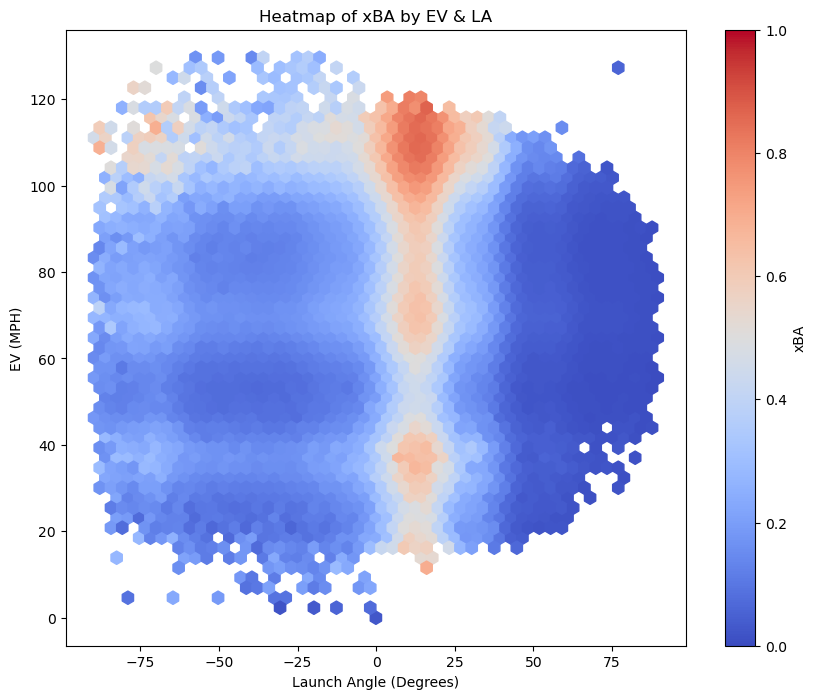

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

hb = plt.hexbin(
    necessary_data['Angle'],
    necessary_data['ExitSpeed'],
    C=necessary_data['xBA'],
    gridsize=50,        # controls resolution
    cmap='coolwarm',
    vmin=0.00,
    vmax=1.00
)

plt.colorbar(hb, label='xBA')
plt.xlabel("Launch Angle (Degrees)")
plt.ylabel("EV (MPH)")
plt.title("Heatmap of xBA by EV & LA")

plt.show()

## Exploring wOBA

We can use publicly available college baseball linear weights as seen here: (https://github.com/nathanblumenfeld/collegebaseball/tree/main/collegebaseball)

In [309]:
## wOBA linear weights

avg_woba = 0.367	
woba_scale = 0.9795	
bb_weight = 0.785404	
hbp_weight = 0.803778	
single_weight = 0.949848	
double_weight = 1.303976	
triple_weight = 1.643932	
hr_weight = 1.977906

## Trusting this is correct for college baseball, can definitely explore more later

In [316]:
necessary_data.sample(15)

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG
775906,"Mercurius, LJ",UNL_REB,Right,"Schmidt, Tate",UWM_PAN,Left,Fastball,Four-Seam,StrikeSwinging,Strikeout,Undefined,Undefined,1,0,91.884840,2216.001003,1:30,5.549360,2.130100,6.282540,17.995250,15.512530,3.874490,0.071510,0.000000,0.000000,0.000000,NaN,NaN,NaN,d6442ab0-f6e5-11ef-80df-7b4233bb4f66,0,0,0.027000,0.032000
344899,"Dudley, Bryson",TEX_BOB,Right,"Meier, Steven",TRO_TRJ,Left,Slider,Slider,InPlay,Undefined,GroundBall,Single,0,0,84.208500,2343.342606,7:15,6.345560,1.582750,5.523000,-1.804730,-2.212210,1.344420,-0.239990,114.788270,6.600588,23.669280,139.215430,26.750205,0.966591,e7378c20-2392-11f0-8f82-6356314279dc,1,1,0.805000,1.346000
924291,"Gilley, Brayden",WIN_EAG,Right,"Nawrocki, Nolan",SOU_GAM,Right,Curveball,Curveball,InPlay,Undefined,LineDrive,Out,1,0,81.342860,2134.978103,6:00,6.349010,1.538990,5.249500,-9.234690,-0.184330,1.044240,-0.014900,95.132740,16.422184,-5.804233,304.674090,-6.088849,3.289671,24bbbab0-ee4d-11ef-9656-25d6dfab45da,0,0,0.595000,0.688000
431106,"Garrett, Miles",VCU_RAM,Right,"Wang, Nick",BOC_EAG,Right,Sinker,Sinker,InPlay,Undefined,GroundBall,Single,0,2,90.082370,1992.229968,2:15,5.262160,2.981340,5.787230,8.768820,19.639420,2.838340,1.056280,95.628450,1.355495,16.747611,70.585670,18.523772,0.555143,9d670df0-f791-11ef-8c5b-fb504e2ece4a,1,1,0.433000,0.414000
121642,"Underwood, Michael",POI_UNI,Right,"Mark, Jayden",WIL_CAR,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,78.942700,2257.837264,12:00,6.188480,1.220710,5.935640,12.530830,-0.038150,2.404140,-0.006110,99.641340,22.469321,-11.424978,355.810180,-12.860377,4.305328,a687e460-fc58-11ef-a92f-1d89bce1a465,0,0,0.553000,1.315000
182589,"Tovar, Daniel",NEV_WOL,Right,"Lee, Ryan",CAL_AGO,Right,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Double,0,1,87.584090,2190.283975,1:00,5.738540,2.048450,6.712080,14.805280,7.657960,2.874270,0.471730,100.791730,19.370453,-31.133961,273.958450,-36.601392,2.581540,b17a09b0-1018-11f0-93fa-9576115e8768,1,2,0.807000,1.666000
392728,"Ojeda, Ricky",CAL_ANT,Left,"Collins, Jack",CAL_MUS,Right,FourSeamFastBall,Four-Seam,InPlay,Undefined,LineDrive,Double,0,0,91.941140,2283.953007,11:15,5.529820,-1.600880,6.863130,18.074420,-7.989300,1.755830,-0.236790,84.297310,23.588607,-31.738748,268.186050,-42.229876,3.392517,58449080-224d-11f0-86d1-ff6aa6877792,1,2,0.486000,1.162000
91535,"Shatwell, Kade",AUS_GOV,Right,"Gasser, Camden",PUR_BOI,Left,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Single,0,0,93.214370,2232.925248,12:30,6.189890,1.626800,5.174130,19.010560,4.508390,2.380540,0.109080,88.412340,12.074615,-15.973034,194.191090,-22.989179,1.900698,d013c510-1fdf-11f0-a560-736589fcf29f,1,1,0.597000,0.453000
678093,"Conway, Elias",DEL_BLU,Left,"Penfield, Landon",COL_CHA,Right,Slider,Curveball,InPlay,Undefined,LineDrive,Double,0,0,78.813890,1968.010596,2:15,5.055490,-1.760510,5.635730,1.725320,0.421730,1.853290,-0.111960,97.947010,18.589214,11.248541,271.619820,17.415991,2.901991,49571ac0-17da-11f0-910c-ad95ae26a9de,1,2,0.631000,1.021000
1253145,"Vega, Dylan",MAR_LIO,Right,"Faucett, Adams",LIM_STO,Right,TwoSeamFastBall,Four-Seam,InPlay,Undefined,GroundBall,Single,0,0,89.313000,2039.662522,1:15,5.652810,1.208010,5.851110,18.235320,12.338790,2.898760,1.337530,66.154140,-26.617895,0.596793,7.276270,-10.241408,0.065068,3d129780-0bff-11f0-920d-2d52e36ffea4,1,1,0.101000,-0.145000


In [354]:
woba_data = master_trackman[['Pitcher', 'PitcherTeam','PitcherThrows', 'Batter', 'BatterTeam', 'BatterSide', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'RelSpeed', 'SpinRate', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ExitSpeed', 'Angle', 'Direction', 'Distance', 'Bearing', 'HangTime', 'PitchUID']]
woba_data = woba_data.dropna(subset = ['PitchCall', 'PlayResult'])
woba_data

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID
0,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,2497.731876,12:30,5.621390,0.510940,5.836200,18.231070,4.190400,1.212030,-0.291350,NaN,NaN,NaN,NaN,NaN,NaN,18b54860-14e7-11f0-938f-b5417cf72451
1,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,2782.722426,11:15,5.533740,0.741550,4.993150,6.645160,-2.487760,4.117590,0.142400,NaN,NaN,NaN,NaN,NaN,NaN,205779d0-14e7-11f0-938f-b5417cf72451
2,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,89.170310,2457.952019,12:30,5.673900,0.637670,6.021180,20.687960,4.343740,2.428360,-1.368630,NaN,NaN,NaN,NaN,NaN,NaN,298b6ed0-14e7-11f0-938f-b5417cf72451
3,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,NaN,NaN,NaN,NaN,NaN,NaN,3189ca00-14e7-11f0-938f-b5417cf72451
4,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,88.799670,2487.422652,12:45,5.699690,0.707000,5.903890,15.885320,5.797090,3.729990,-1.122990,NaN,NaN,NaN,NaN,NaN,NaN,445b4b40-14e7-11f0-938f-b5417cf72451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354508,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,StrikeCalled,Undefined,Undefined,Undefined,0,0,85.578950,2309.550718,11:00,5.343220,2.092230,6.157400,4.977010,-1.972250,2.480910,-0.516160,NaN,NaN,NaN,NaN,NaN,NaN,5bdd03d0-11d6-11f0-b75a-15defc8841bc
1354509,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,FoulBallNotFieldable,Undefined,Undefined,Undefined,0,0,87.422390,2299.056403,10:45,5.260250,2.269660,6.038550,6.124730,-3.600440,1.818140,0.106260,46.703320,50.600354,120.524254,116.274000,126.704006,3.081668,6451ee90-11d6-11f0-b75a-15defc8841bc
1354510,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,InPlay,Undefined,Popup,Out,1,0,87.589110,2338.856413,10:30,5.275490,2.220830,6.206060,4.687760,-3.380080,2.490030,-0.199540,68.609820,40.223331,-3.564189,197.333360,8.108297,4.536495,6f267430-11d6-11f0-b75a-15defc8841bc
1354511,"Hicks, Garrett",ARI_WIL,Right,"Hairston, Landon",ARI_SUN,Left,Cutter,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,85.486640,2312.444806,10:45,5.265290,2.252450,6.183890,7.524530,-4.503700,1.809560,-1.219740,NaN,NaN,NaN,NaN,NaN,NaN,82a5c1a0-11d6-11f0-b75a-15defc8841bc


In [355]:
woba_data['PitchCall'].unique()

array(['BallCalled', 'StrikeCalled', 'InPlay', 'StrikeSwinging',
       'FoulBallNotFieldable', 'BallinDirt', 'HitByPitch',
       'FoulBallFieldable', 'BallIntentional', 'Undefined',
       'AutomaticBall', 'Ballintentional', 'Strikecalled', 'FoulBall',
       'BallInDirt', 'AutomaticStrike', 'BallIInDirt'], dtype=object)

In [356]:
woba_data = woba_data[
    (woba_data['PitchCall'].isin(['InPlay', 'HitByPitch'])) | 
    (woba_data['KorBB'].isin(['Strikeout', 'Walk']))
]

woba_data.head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID
3,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,NaN,NaN,NaN,NaN,NaN,NaN,3189ca00-14e7-11f0-938f-b5417cf72451
8,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.176990,2481.172792,12:30,5.647470,0.672960,5.867700,15.070720,2.981030,3.871040,0.397090,NaN,NaN,NaN,NaN,NaN,NaN,8c5be940-14e7-11f0-938f-b5417cf72451
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451


In [357]:
woba_data['BB'] = (woba_data['KorBB'] == 'Walk').astype(int)
woba_data['HBP'] = (woba_data['PitchCall'] == 'Hit By Pitch').astype(int)
woba_data['Single'] = (woba_data['PlayResult'].isin(['Single', 'SIngle'])).astype(int)
woba_data['Double'] = (woba_data['PlayResult'] == 'Double').astype(int)
woba_data['Triple'] = (woba_data['PlayResult'].isin(['Triple', 'triple'])).astype(int)
woba_data['HomeRun'] = (woba_data['PlayResult'].isin(['Home Run', 'Homerun', 'HomeRun'])).astype(int)

woba_ucsd = woba_data[(woba_data['BatterTeam'] == 'CSD_TRI')]
woba_ucsd

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,BB,HBP,Single,Double,Triple,HomeRun
8102,"Rudd, Andrew",CAL_LAN,Right,"Potestio, Anthony",CSD_TRI,Left,ChangeUp,Changeup,InPlay,Undefined,GroundBall,Single,0,0,81.405610,1703.263930,1:30,6.098290,2.334110,6.322190,15.512130,14.993950,1.493270,0.488210,95.942920,8.876809,20.931431,125.675060,23.805471,1.027225,5da2a3b0-f18c-11ef-9456-e7fd19fa9ca5,0,0,1,0,0,0
8109,"Rudd, Andrew",CAL_LAN,Right,"Lazuka, Noah",CSD_TRI,Right,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Single,0,0,86.983280,2055.587425,12:45,6.080890,1.951060,6.489350,14.887060,5.484020,2.209730,-0.747300,103.880950,1.100340,21.504723,81.960300,23.668520,0.578172,bfdd1fb0-f18c-11ef-9456-e7fd19fa9ca5,0,0,1,0,0,0
8114,"Rudd, Andrew",CAL_LAN,Right,"Leopard, Alex",CSD_TRI,Left,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,75.282080,2131.509495,6:15,6.254680,2.037010,5.340810,-9.753900,-1.371970,1.927620,-0.404780,99.586430,47.082161,28.532669,274.406300,35.006366,6.519484,06853290-f18d-11ef-9456-e7fd19fa9ca5,0,0,0,0,0,0
8115,"Rudd, Andrew",CAL_LAN,Right,"Crossland, Michael",CSD_TRI,Right,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Double,0,2,87.452080,2057.553303,1:00,6.154180,2.077860,6.341940,14.538240,8.095830,3.162810,-0.212580,100.229150,21.534737,11.245996,346.432610,24.851012,4.366282,21a7e9f0-f18d-11ef-9456-e7fd19fa9ca5,0,0,0,1,0,0
8119,"Rudd, Andrew",CAL_LAN,Right,"Camacho, Gabe",CSD_TRI,Left,Slider,Curveball,InPlay,Undefined,Popup,Out,1,0,76.116500,2172.749930,7:15,6.264020,2.134900,5.290020,-3.708980,-3.823310,2.160380,0.293000,80.954380,66.735694,39.722696,NaN,NaN,NaN,5ad7f580-f18d-11ef-9456-e7fd19fa9ca5,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302939,"Rodgers, Peyton",SAN_AZT,Right,"Allen, J.C.",CSD_TRI,Right,Fastball,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.386940,2106.646605,2:15,5.345820,2.467690,4.789630,10.743190,20.101740,1.794910,-0.329040,102.268340,-11.487379,-8.089295,10.931780,-4.895118,0.062016,e6af6f20-ee86-11ef-8e70-eff9880e989d,0,0,0,0,0,0
1302960,"Rodgers, Peyton",SAN_AZT,Right,"Martinez, Trevian",CSD_TRI,Right,Fastball,Sinker,InPlay,Undefined,GroundBall,Out,1,0,88.393210,2109.354944,1:45,5.504120,2.237700,4.951470,16.444650,19.895560,2.400950,-0.901460,100.672990,-16.393678,20.401502,8.177210,25.700394,0.053845,9e59c160-ee88-11ef-8e70-eff9880e989d,0,0,0,0,0,0
1302962,"Rodgers, Peyton",SAN_AZT,Right,"Hackworth, Patrick",CSD_TRI,Left,Fastball,Sinker,InPlay,Undefined,Popup,Error,0,0,89.180920,2091.785197,1:30,5.443520,2.226300,4.695140,21.048710,19.103320,3.205110,0.004070,87.333590,74.630060,7.081042,NaN,NaN,NaN,bf18ef20-ee88-11ef-8e70-eff9880e989d,0,0,0,0,0,0
1302967,"Rodgers, Peyton",SAN_AZT,Right,"Thacker, Cooper",CSD_TRI,Right,Slider,Slider,StrikeSwinging,Strikeout,Undefined,Undefined,1,0,80.814720,2888.715974,8:15,5.169530,2.493400,4.721330,-2.857400,-8.696890,1.318890,-1.257530,NaN,NaN,NaN,NaN,NaN,NaN,0f1d6690-ee89-11ef-8e70-eff9880e989d,0,0,0,0,0,0


In [358]:
pitch_count = woba_ucsd.groupby('Batter').size().reset_index(name='PAs')
pitch_count.head()

,Batter,PAs
0,"Allen, J.C.",143
1,"Ambriz, Andy",2
2,"Areliz, Julian",1
3,"Camacho, Gabe",129
4,"Crossland, Michael",161


In [359]:
## woba function

def calculate_woba(group):
    
    woba = ((bb_weight * group['BB'].sum()) + (hbp_weight * group['HBP'].sum()) + (single_weight * group['Single'].sum()) + (double_weight * group['Double'].sum()) + (triple_weight * group['Triple'].sum()) + (hr_weight * group['HomeRun'].sum())) / group['PitchUID'].count()

    return round(woba, 3)

In [360]:
woba_ucsd = woba_ucsd.groupby('Batter').apply(calculate_woba).reset_index(name = 'wOBA')
woba_ucsd = woba_ucsd.merge(pitch_count, on = ['Batter'], how = 'left')
woba_ucsd

,Batter,wOBA,PAs
0,"Allen, J.C.",0.378000,143
1,"Ambriz, Andy",0.000000,2
2,"Areliz, Julian",0.000000,1
3,"Camacho, Gabe",0.325000,129
4,"Crossland, Michael",0.406000,161
5,"Davidson, Garrett",0.190000,22
6,"Gonzalez, Emiliano",0.357000,133
7,"Hackworth, Patrick",0.355000,117
8,"Lanier, Delshaun",0.229000,44
9,"Lazuka, Noah",0.360000,105
